## Explore Data Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# library
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Teaching/Advanced Research in Deep Learning/data/pneumonia/test/PNEUMONIA')
os.listdir()[:5]

['person100_bacteria_477.jpeg',
 'person101_bacteria_486.jpeg',
 'person100_bacteria_480.jpeg',
 'person100_bacteria_475.jpeg',
 'person108_bacteria_506.jpeg']

In [ ]:
import matplotlib.image as pltm
import cv2

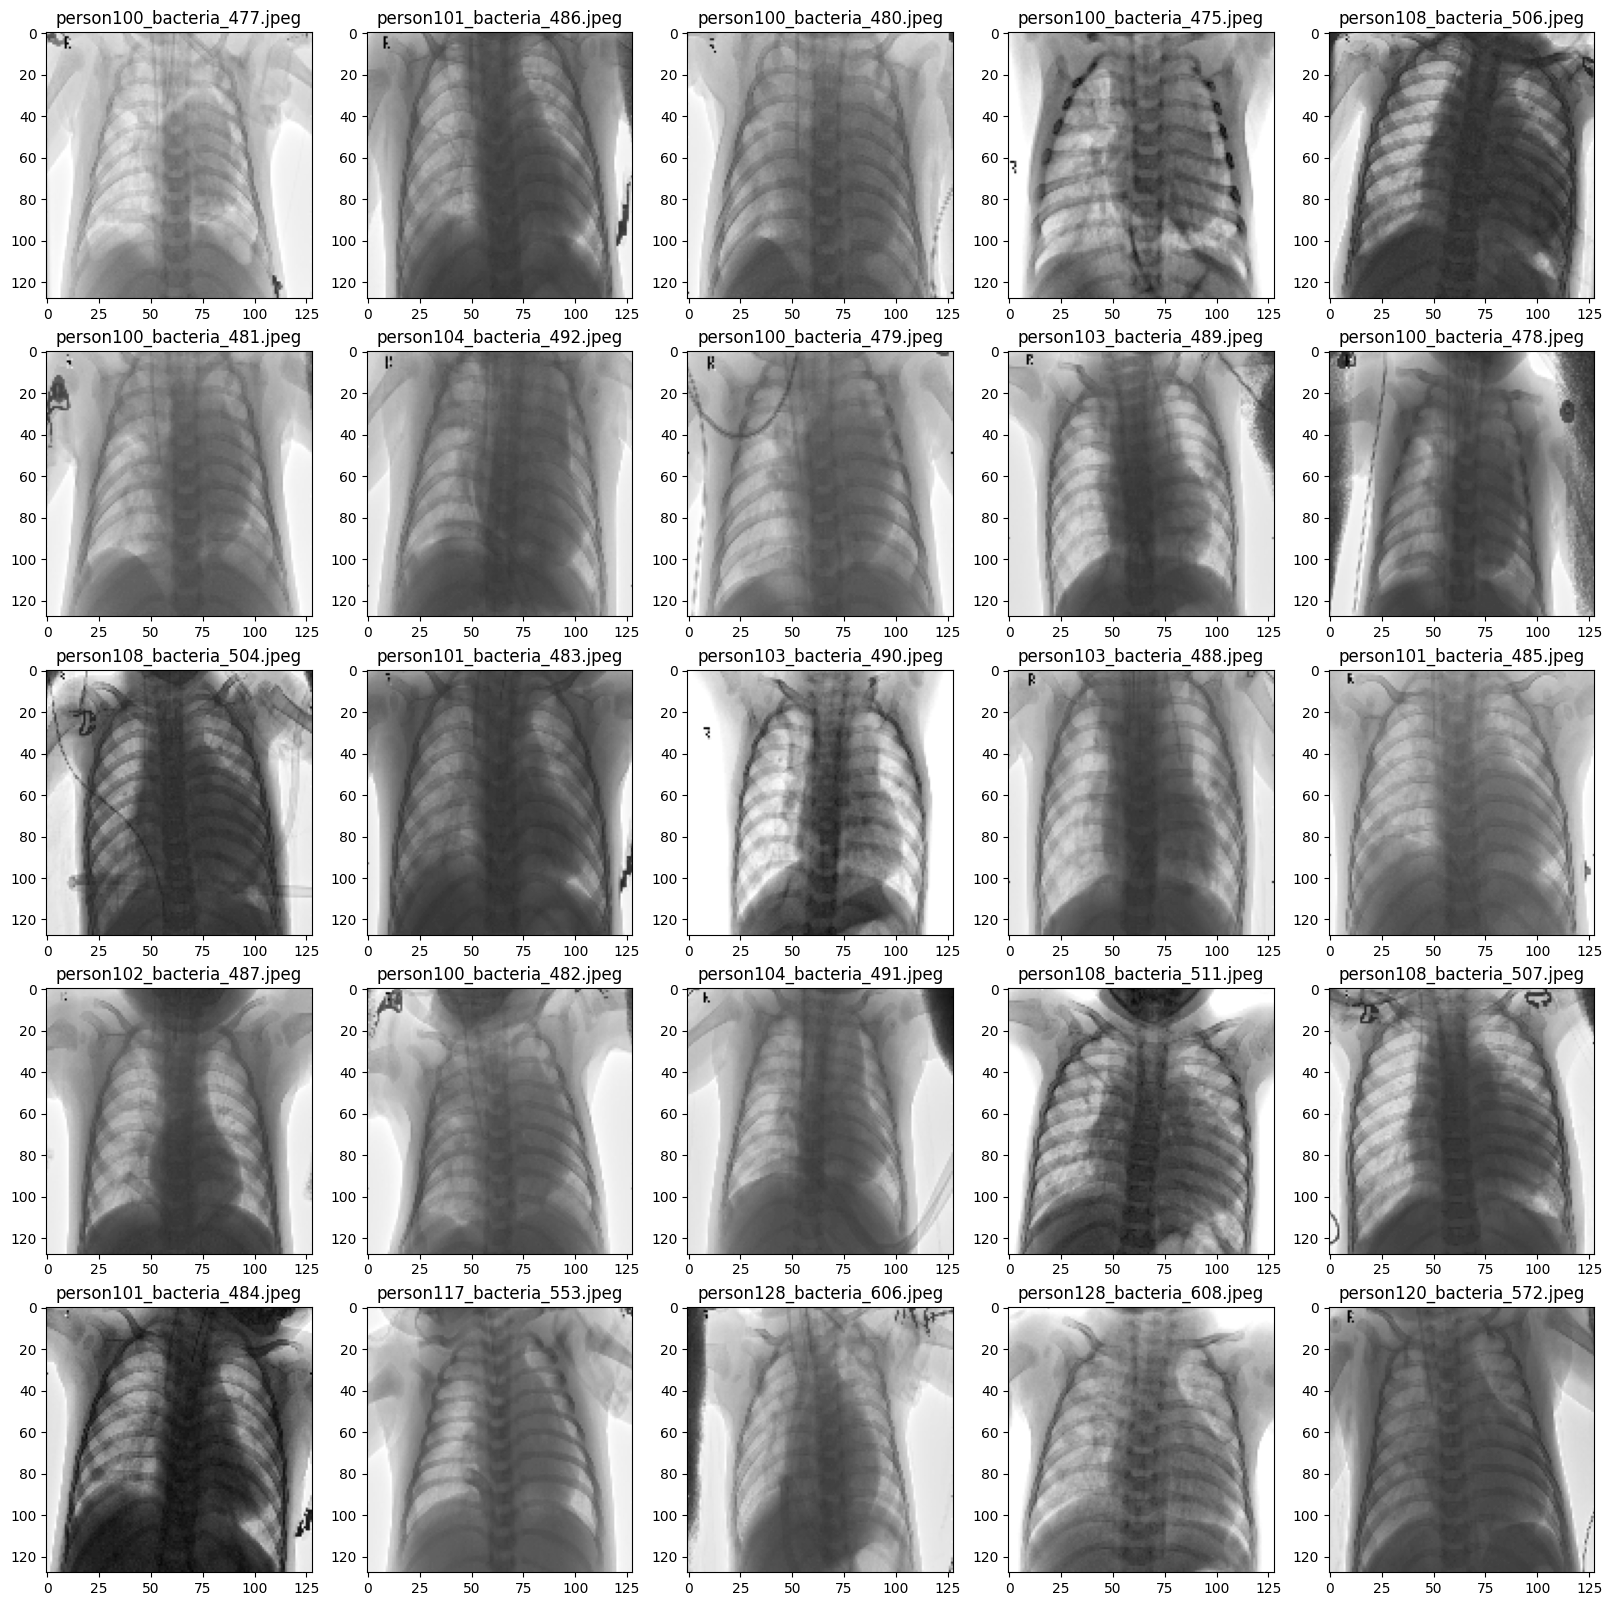

In [ ]:
# display
plt.figure(figsize=(20, 20))
ii = 1
for i in os.listdir()[:25]:
    tmp = pltm.imread(i)
    tmp = cv2.resize(tmp, (128, 128))
    plt.subplot(5, 5, ii)
    plt.imshow(tmp, cmap='binary')
    plt.title(i)
    ii += 1

plt.show()

## Load Data

In [ ]:
from tqdm import tqdm

In [ ]:
# read data and concatenate
pneumonia_case = []
for i in tqdm(os.listdir()):
    tmp = pltm.imread(i)
    tmp = cv2.resize(tmp, (128, 128))
    if len(tmp.shape) > 2:
        tmp = tmp[:,:,0]
    else:
        tmp = tmp
    pneumonia_case.append(tmp)

100%|██████████| 390/390 [00:02<00:00, 130.31it/s]


In [ ]:
# display dimensions
pneumonia_case = np.asarray(pneumonia_case)
pneumonia_case.shape

(390, 128, 128)

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Teaching/Advanced Research in Deep Learning/data/pneumonia/test/NORMAL')
os.listdir()[:5]

['IM-0049-0001.jpeg',
 'IM-0023-0001.jpeg',
 'IM-0009-0001.jpeg',
 'IM-0007-0001.jpeg',
 'IM-0030-0001.jpeg']

In [ ]:
# read data and concatenate
healthy_case = []
for i in tqdm(os.listdir()):
    tmp = pltm.imread(i)
    tmp = cv2.resize(tmp, (128, 128))
    if len(tmp.shape) > 2:
        tmp = tmp[:,:,0]
    else:
        tmp = tmp
    healthy_case.append(tmp)

100%|██████████| 234/234 [00:21<00:00, 11.01it/s]


In [ ]:
# display dimensions
healthy_case = np.asarray(healthy_case)
healthy_case.shape

(234, 128, 128)

In [ ]:
# display dimensions
print(pneumonia_case.shape)
print(healthy_case.shape)

(390, 128, 128)
(234, 128, 128)


## Define Features

In [ ]:
# define target
Y = np.concatenate([np.ones(pneumonia_case.shape[0]), np.zeros(healthy_case.shape[0])])
Y.shape

(624,)

In [ ]:
# concatenate features
X = np.concatenate([pneumonia_case, healthy_case], 0)
X.shape

(624, 128, 128)

In [ ]:
# change directory
os.chdir('/content/drive/MyDrive/Colab Notebooks/Teaching/Advanced Research in Deep Learning/data/pneumonia/test/')
os.listdir()

['NORMAL', 'PNEUMONIA', 'X.npy', 'Y.npy', 'model.png']

In [ ]:
# save
# np.save('X.npy', X)
# np.save('Y.npy', Y)

If lost connection or restart, load data from this step.

In [ ]:
# load
# X = np.load('X.npy')
# Y = np.load('Y.npy')

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(418, 128, 128)
(206, 128, 128)
(418, 2)
(206, 2)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], 128, 128, 1))
X_test  = X_test.reshape((X_test.shape[0], 128, 128, 1))

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(418, 128, 128, 1)
(206, 128, 128, 1)
(418, 2)
(206, 2)


## Build Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
def custom_convnet(input_dim, num_classes):
    # Create the base model using VGG16 with ImageNet weights and without the top layers
    base_model = tf.keras.applications.VGG16(
        include_top=False, weights='imagenet', input_shape=input_dim
    )

    # Freeze the base model so its weights won't be updated during training
    base_model.trainable = False

    # Get the output of the base model
    x = base_model.output

    # Add a Global Average Pooling layer to reduce the spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected dense layer with 1024 units and ReLU activation
    x = Dense(1024, activation='relu')(x)

    # Add a dropout layer with a 50% dropout rate to prevent overfitting
    x = Dropout(0.5)(x)

    # Add another fully connected dense layer with 1024 units and ReLU activation
    x = Dense(1024, activation='relu')(x)

    # Add another dropout layer with a 50% dropout rate to prevent overfitting
    x = Dropout(0.5)(x)

    # Add a final dense layer with softmax activation for classification
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the custom model by connecting the input and output layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Return the custom model
    return model


In [ ]:
input_dim = (128, 128, 3)  # Input dimensions for your dataset
num_classes = 2  # Number of classes in your dataset
model = custom_convnet(input_dim, num_classes)

In [ ]:
# compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'] )

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
import numpy as np

def grayscale_to_rgb(images):
    return np.repeat(images, 3, axis=-1)

In [ ]:
X_train.shape, X_test.shape

((418, 128, 128, 1), (206, 128, 128, 1))

In [ ]:
X_train = grayscale_to_rgb(X_train)
X_test = grayscale_to_rgb(X_test)
X_train.shape, X_test.shape

((418, 128, 128, 3), (206, 128, 128, 3))

In [ ]:
# train
with tf.device('/GPU:0'):
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        batch_size=32,
        epochs=50 )

Epoch 1/50
12/12 [==============================] - 7s 277ms/step - loss: 2.7864 - accuracy: 0.7154 - val_loss: 0.3634 - val_accuracy: 0.9286
Epoch 2/50
12/12 [==============================] - 1s 50ms/step - loss: 1.8960 - accuracy: 0.8271 - val_loss: 0.5479 - val_accuracy: 0.9286
Epoch 3/50
12/12 [==============================] - 1s 49ms/step - loss: 1.8299 - accuracy: 0.8484 - val_loss: 0.2505 - val_accuracy: 0.9524
Epoch 4/50
12/12 [==============================] - 1s 50ms/step - loss: 1.8013 - accuracy: 0.8564 - val_loss: 0.6914 - val_accuracy: 0.9048
Epoch 5/50
12/12 [==============================] - 1s 50ms/step - loss: 1.6874 - accuracy: 0.8537 - val_loss: 0.5698 - val_accuracy: 0.9048
Epoch 6/50
12/12 [==============================] - 1s 50ms/step - loss: 1.2084 - accuracy: 0.8564 - val_loss: 0.7038 - val_accuracy: 0.8810
Epoch 7/50
12/12 [==============================] - 1s 50ms/step - loss: 1.0981 - accuracy: 0.8617 - val_loss: 0.9679 - val_accuracy: 0.8333
Epoch 8/50
1

In [ ]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 211ms/step - loss: 0.5624 - accuracy: 0.8932


[0.5623656511306763, 0.893203854560852]

In [ ]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 39ms/step


In [ ]:
print(y_pred.shape)
print(y_test.shape)

(206, 2)
(206, 2)


In [ ]:
y_pred_lab = np.argmax(y_pred, 1)
y_test_lab = np.argmax(y_test, 1)

In [ ]:
print(y_pred_lab.shape)
print(y_test_lab.shape)

(206,)
(206,)


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['Non-pneumonia', 'Pneumonia']
print(classification_report(y_true=y_test_lab, y_pred=y_pred_lab, target_names=target_names))

               precision    recall  f1-score   support

Non-pneumonia       0.94      0.72      0.82        69
    Pneumonia       0.88      0.98      0.92       137

     accuracy                           0.89       206
    macro avg       0.91      0.85      0.87       206
 weighted avg       0.90      0.89      0.89       206



## Class Activation Map

Class Activation Mapping (CAM) is a technique used to visualize the parts of an input image that contribute the most to the classification decision made by a Convolutional Neural Network (CNN) [1]. By using CAM, we can gain insights into which regions of the image are the most relevant for a specific class, thus helping to understand the network's decision-making process.

A typical CNN consists of a series of convolutional and pooling layers, followed by one or more fully connected layers. In the case of CAM, the fully connected layers are replaced with Global Average Pooling (GAP) and a final dense layer for classification. The CAM visualization is obtained by computing a weighted sum of the feature maps from the last convolutional layer, where the weights correspond to the weights of the final dense layer for a specific class.

```java
Input Image
      |
Convolutional and Pooling Layers
      |
Last Convolutional Layer (Feature Maps)
      |
Global Average Pooling
      |
Dense Layer (Classification)
      |
Class Activation Mapping (Visualization)
```

To create a Class Activation Map, you need to:

1. Train a CNN with GAP and a dense layer for classification.
2. Extract the feature maps from the last convolutional layer for a given input image.
3. Compute the CAM visualization by calculating the weighted sum of these feature maps, using the weights of the final dense layer for the desired class.

The resulting CAM visualization highlights the regions of the input image that have the most impact on the classification decision for the chosen class, providing a better understanding of the CNN's inner workings.

Citation:
[1] Zhou, B., Khosla, A., Lapedriza, A., Oliva, A., & Torralba, A. (2016). Learning Deep Features for Discriminative Localization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). [Link](https://openaccess.thecvf.com/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

## Grad-Cam

In [ ]:
# check out layers
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [ ]:
last_conv_layer_name = 'block4_conv3'

In [ ]:
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output] )

In [ ]:
# if set as None, don't use pre-trained model
pred_index = None

# which picture
which_pic = 20

# img_array
img_array = X_train[which_pic].reshape((1, 128, 128, 3))

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

In [ ]:
# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

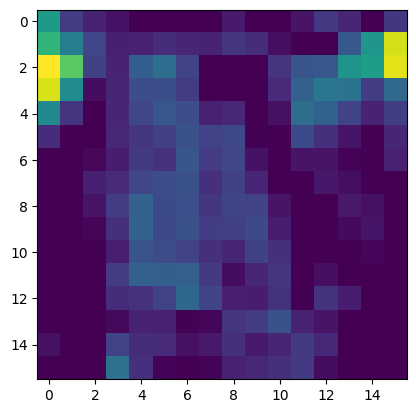

In [ ]:
# plot
plt.imshow(heatmap)

In [ ]:
# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

In [ ]:
import matplotlib.cm as cm

In [ ]:
# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

<ipython-input-139-f23510276f45>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [ ]:
img = X_train[which_pic][:, :, 0:1].reshape((128, 128, 1))
img.shape

(128, 128, 1)

In [ ]:
# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

In [ ]:
alpha = .4

In [ ]:
jet_heatmap = np.mean(jet_heatmap, 2).reshape((128, 128, 1))

In [ ]:
jet_heatmap.shape

(128, 128, 1)

In [ ]:
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * alpha + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

Available options for color pallette:

```
'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
```

Other color gradients
```
'viridis', 'plasma', 'inferno', 'magma', 'cividis'
```


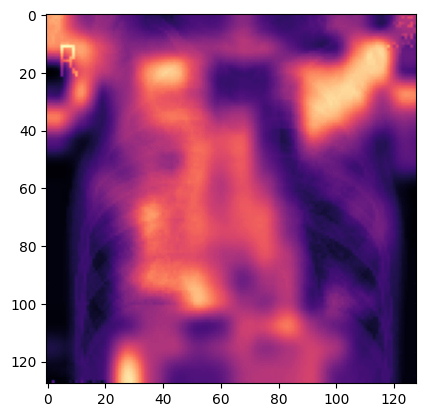

In [ ]:
# @title Graph User Interface (GUI)- INPUT DATA
alpha = 0.85 # @param {type:"slider", min:0.00, max:1.00, step:0.05}
beta  = 0.16 # @param {type:"slider", min:0.00, max:1.00, step:0.01}

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * alpha + img * beta
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

plt.imshow(superimposed_img, cmap='magma')

Investigation ends here.